In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

sys.path.append(os.path.join('..'))

from counting_boats.boat_utils import spatial_helpers

In [3]:
coverage = pd.read_csv('D:/results/coverage.csv')
coverage['date'] = pd.to_datetime(coverage['date'])

reference_gon = "C:\\ML_Software\\data\\polygons\\moreton.geojson"

def date_2_udm(date):
    y, m, d = date.split('-')
    fsdate = f"{y}{m}{d}"
    udm = [f for f in os.listdir("UDM") if fsdate in f][0]
    return os.path.join("UDM", udm)

# print(coverage.head())
# coverage = coverage[coverage['date'] == '2016-04-08']
# print(coverage)

# for i in range(0, len(coverage)):
#     row = coverage.iloc[i]
#     poly = row['polygon']
#     coverage_n = area_coverage.area_coverage_poly(reference=reference_gon, polygon=poly)
#     # put the coverage in the coverage column
#     udm = date_2_udm(row["date"])
#     cloud_cover, _ = area_coverage.cloud_coverage_udm(udm)
#     coverage.iloc[i, coverage.columns.get_loc('area_coverage')] = coverage_n
#     coverage.iloc[i, coverage.columns.get_loc('cloud_coverage')] = cloud_cover
#     print(row["date"], coverage_n, cloud_cover)

# save the coverage csv again
# coverage.to_csv('coverage.csv', index=False)


Year range: 2016-07-03T00:00:00.000000000 to 2022-01-15T00:00:00.000000000


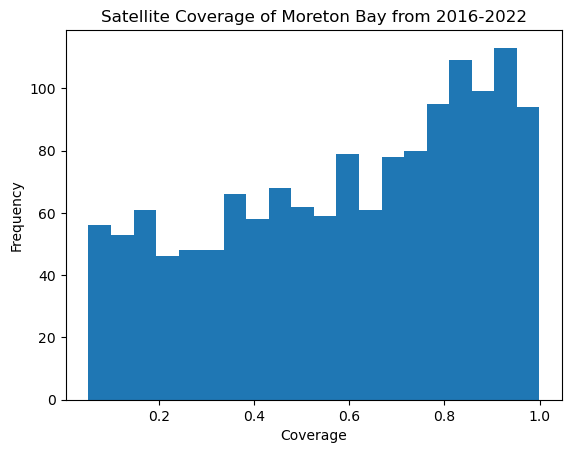

In [4]:
all_cov = coverage[coverage['area_coverage'] > 0.05]['area_coverage'].values
all_cov = all_cov[all_cov <= 1.0]

year_min = min(coverage['date'].values)
year_max = max(coverage['date'].values)
print(f"Year range: {year_min} to {year_max}")


# plot a histogram of the coverage
plt.hist(all_cov, bins=20)
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.title('Satellite Coverage of Moreton Bay from 2016-2022')
plt.show()


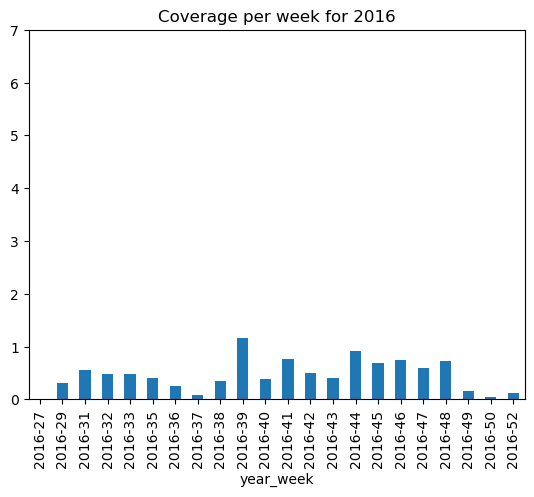

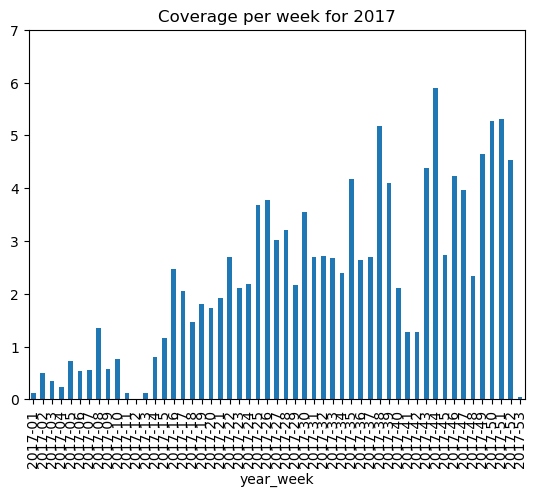

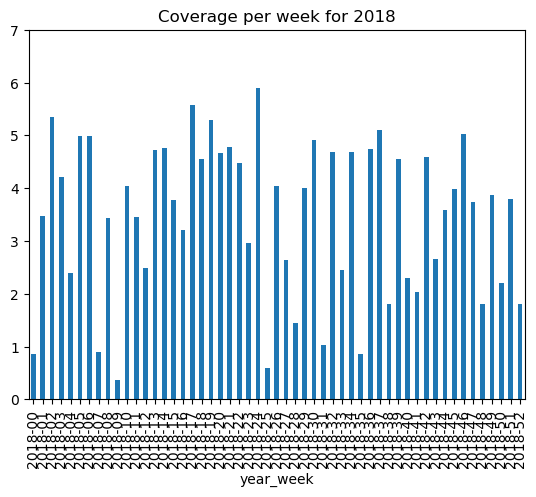

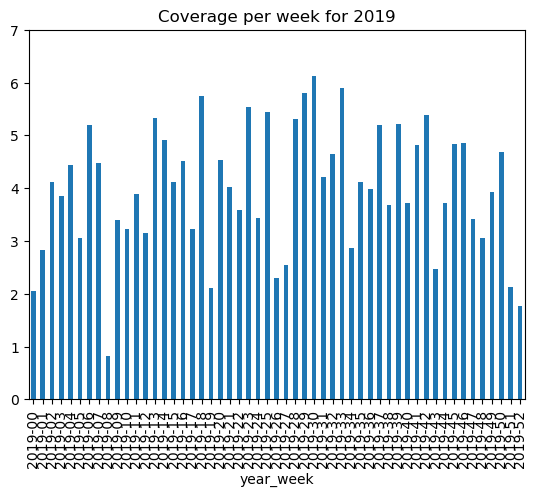

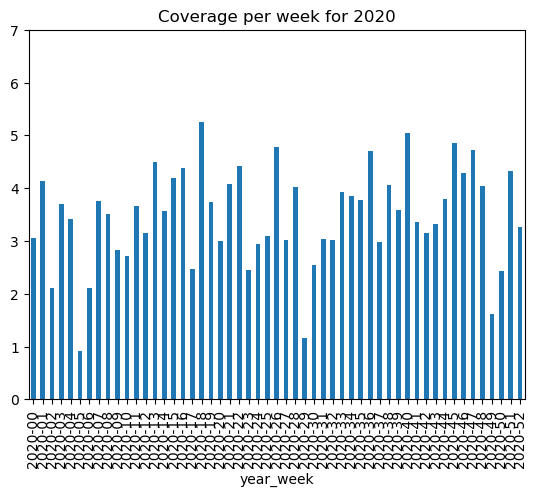

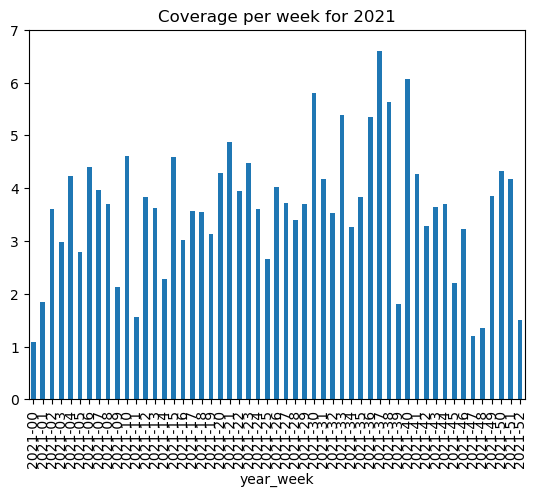

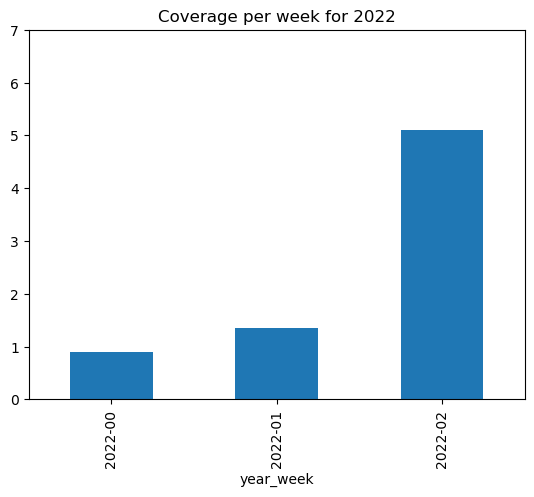

In [5]:
# bar chart of images per week
coverage["year_week"] = coverage["date"].dt.strftime('%Y-%U')
# coverage["year_week"].value_counts().sort_index().plot(kind='bar')
# plt.show()
# bar chart of coverage per week (e.g images scaled by coverage value)
for year in range(2016, 2023):
    coverage[coverage["date"].dt.year == year].groupby("year_week")["area_coverage"].sum().plot(kind='bar', ylim=(0, 7))
    plt.title(f"Coverage per week for {year}")
    plt.show()
# coverage.groupby("year_week")["area_coverage"].mean().plot(kind='bar')

C:\Users\turner30\AppData\Local\Temp\ipykernel_14904\1744942484.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  detections['date'] = pd.to_datetime(detections['date'])


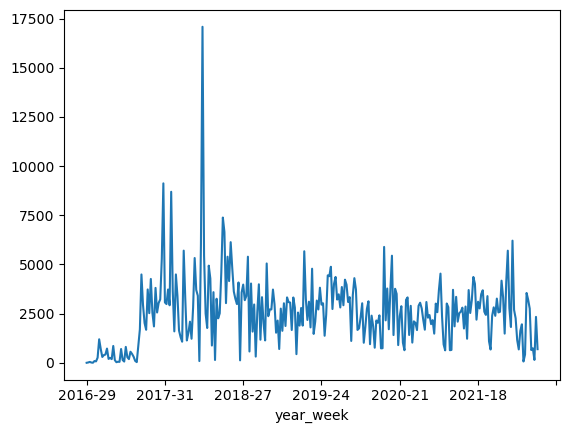

In [6]:
# plot detections/week
detections = pd.read_csv('D:/Results/boat_detections.csv')
detections['date'] = pd.to_datetime(detections['date'])
detections["year_week"] = detections["date"].dt.strftime('%Y-%U')
detections["year_week"].value_counts().sort_index().plot()
plt.show()


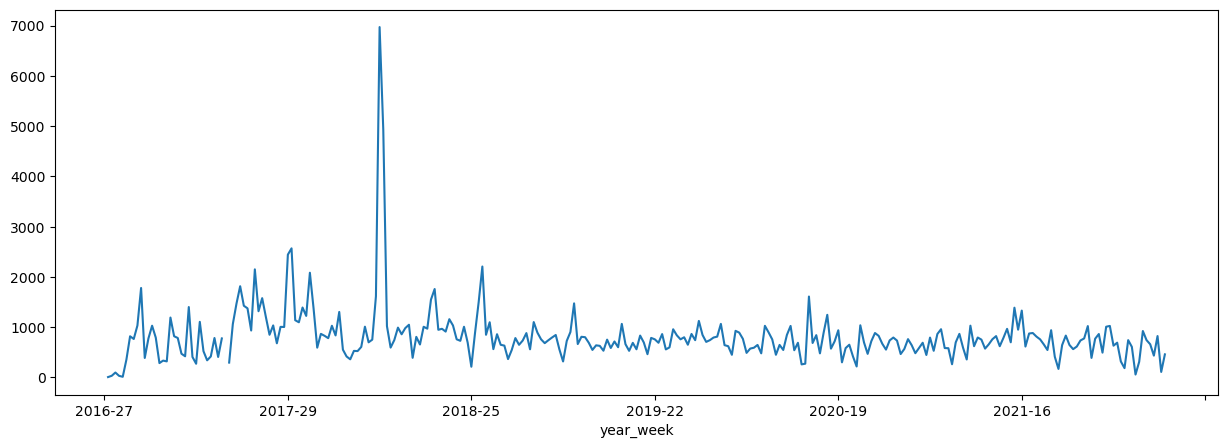

In [7]:
# plot detections divided by coverage over time
detections["year_week"] = detections["date"].dt.strftime('%Y-%U')
weekly_counts = detections["year_week"].value_counts()
weekly_counts = weekly_counts.sort_index()
coverage["year_week"] = coverage["date"].dt.strftime('%Y-%U')
normalized_counts_weekly = weekly_counts / coverage.groupby("year_week")["area_coverage"].sum()
normalized_counts_weekly.plot(figsize=(15, 5))
plt.show()



Q1: 132.0, Q2: 737.0, IQR: 605.0
Outliers:
date
2017-05-15    1802
2017-07-20    1652
2017-07-22    2460
2017-07-24    1944
2017-07-26    1934
2017-07-28    1780
2017-07-29    2200
2017-08-28    1860
2017-08-31    1688
2017-10-28    1666
2018-01-05    1912
2018-01-07    1924
2018-01-08    3356
2018-01-10    7938
2018-04-14    2772
2018-04-15    2142
2018-04-16    2446
2018-05-20    1681
2019-04-06    2979
Name: count, dtype: int64


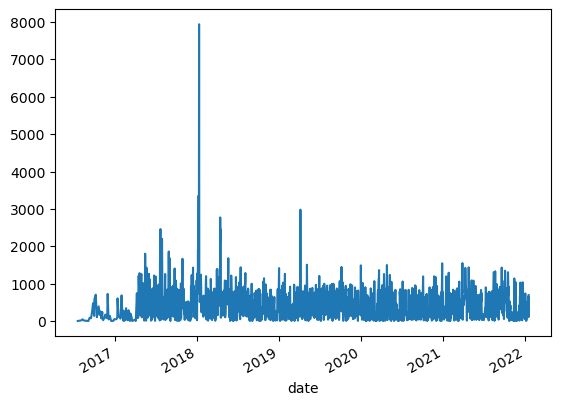

In [71]:
from counting_boats.boat_utils.image_cutting_support import create_unpadded_png
import subprocess
import pathlib
ARCHIVE_DIR = "U:\\Research\\Projects\\sef\\livingplayingmb\\Boat Detection TMBF\\PlanetArchive"
# all zips are of form 'moreton_YYYYMMDD.zip'
def show_image_for_date(date, delete=True):
    zip_name = f"moreton_{date.replace('-', '')}.zip"
    # get the zip file from the archive 
    zip_path = os.path.join(ARCHIVE_DIR, zip_name)
    # make sure spaces are safe for child process
    # extract the zip file
    # unzip the file to this directory:
    unzip_dir = "D:/temp"
    print(f"unzipping {zip_path} to {unzip_dir}")
    result = subprocess.run(f'powershell -command "Expand-Archive -Path \'{zip_path}\' -DestinationPath {unzip_dir} -Force"',
                            capture_output=True, text=True, shell=True)
    print(result.stdout)
    print(result.stderr)

    if result.returncode != 0:
        raise ChildProcessError("Unzip failed")
    # get the image file
    print(f"Creating PNG")
    create_unpadded_png(unzip_dir, unzip_dir, "composite.tif")
    # show the image with matplotlib
    image = plt.imread(os.path.join(unzip_dir, "composite.png"))
    plt.imshow(image)
    plt.show()
    # delete the directory
    if delete:
        os.system(f"rm -rf {unzip_dir}")

# normalise boat detections each day by coverage
daily_counts = detections["date"].value_counts().sort_index()
normalized_counts_daily = daily_counts  #/ coverage.groupby("date")["area_coverage"].sum()
normalized_counts_daily.plot()
# find outliers
Q1 = normalized_counts_daily.quantile(0.25)
Q3 = normalized_counts_daily.quantile(0.75)
IQR = Q3 - Q1

print(f"Q1: {Q1}, Q2: {Q3}, IQR: {IQR}")

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = normalized_counts_daily[(normalized_counts_daily < lower_bound) | (normalized_counts_daily > upper_bound)]

print("Outliers:")
print(outliers)








In [72]:
# sort outliers by how much they are outliers
outliers = outliers.sort_values(key=lambda x: abs(x - normalized_counts_daily.mean()), ascending=False)
print("Sorted outliers:")
print(outliers)
# show_image_for_date(outliers.index[0].strftime('%Y-%m-%d'), delete=True)


Sorted outliers:
date
2018-01-10    7938
2018-01-08    3356
2019-04-06    2979
2018-04-14    2772
2017-07-22    2460
2018-04-16    2446
2017-07-29    2200
2018-04-15    2142
2017-07-24    1944
2017-07-26    1934
2018-01-07    1924
2018-01-05    1912
2017-08-28    1860
2017-05-15    1802
2017-07-28    1780
2017-08-31    1688
2018-05-20    1681
2017-10-28    1666
2017-07-20    1652
Name: count, dtype: int64
unzipping U:\Research\Projects\sef\livingplayingmb\Boat Detection TMBF\PlanetArchive\moreton_20180110.zip to D:/temp


Creating PNG


MemoryError: Unable to allocate 9.20 GiB for an array with shape (41641, 14830, 4) and data type float32

<Figure size 640x480 with 1 Axes>

In [38]:
# on subplots, plot the total boats detected per week as bars, one plot per year. Do stacked bars, with weekday/weekend as different colours
# Aggregate data
detections['week'] = detections['date'].dt.isocalendar().week
detections['year'] = detections['date'].dt.year
detections['is_weekend'] = detections['date'].dt.dayofweek >= 5 # 5 and 6 are Saturday and Sunday

grouped_counts = detections.groupby(['year', 'week', 'is_weekend']).size()

grouped_counts.head()


year  week  is_weekend
2016  29    False          2
      31    False         18
      32    False         46
      33    False         15
      35    False          5
dtype: int64

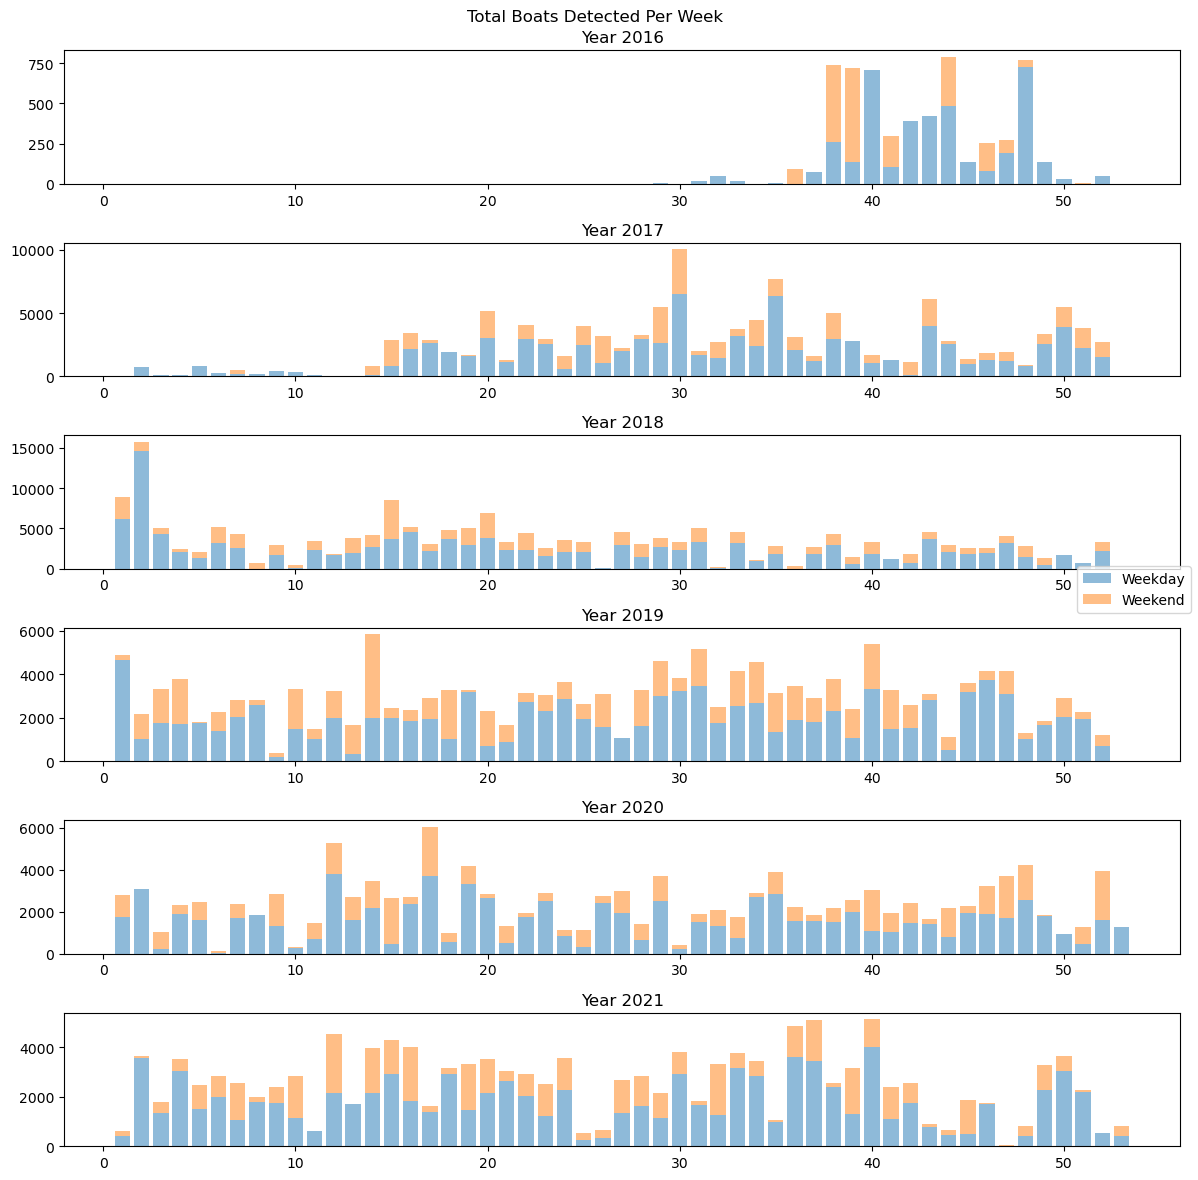

In [70]:

# Plot
fig, axs = plt.subplots(6, 1, figsize=(12, 12))
for i, year in enumerate(range(2016, 2022)):
    bottom = np.zeros(53)
    for j, weekend in enumerate([False, True]):
        data = grouped_counts[year].loc[:, weekend, :] # this is a series with week, and value
        # make sure data has all weeks, and fill in missing weeks with 0
        data = data.reindex(range(1, 54), fill_value=0)
        ax = axs[i]
        ax.bar(data.index, data.values, label='Weekend' if weekend else 'Weekday', alpha=0.5, bottom=bottom)
        bottom += data.values
        ax.set_title(f"Year {year}")
# use one legend fot the whole plot with Weekday and Weekendk
fig.legend(['Weekday', 'Weekend'], loc='center right')
# add title
fig.suptitle("Total Boats Detected Per Week")
plt.tight_layout()
plt.show()





